# Basic regression using Python and Statsmodels -- a case study using the NHANES data

This notebook introduces some of the main ideas of regression analysis,
focusing on the practical aspects of fitting regression models in
Python using the [Statsmodels](http://www.statsmodels.org)
package. We will also be using the
[Pandas](http://pandas.pydata.org) library for data management, and
the [Numpy](http://www.numpy.org) library for numerical
calculations.

At a high level, regression analysis is a way of relating *inputs*
to *outputs*.  For example, if we want to understand how the fuel
efficiency of a car, measured in gallons per mile, relates to the
vehicle weight and engine displacement, then the vehicle weight and
engine displacement could be taken as the inputs, with the fuel efficiency
as the output.  Note that this does not mean that we view
vehicle weight and engine displacement as being the only direct
determinants of fuel efficiency.  For example, the cross sectional
area of the vehicle would also matter a lot (for aerodynamics).
Regression modeling can be used when we have one or more input
factors that may partially explain the output, allowing us to
estimate how the inputs and outputs are statistically
related.

Regression analysis has a long history, with roots in many different
fields.  As a result, there are multiple terms
for many of the key concepts.  For example, the "output" discussed above is
often called the *dependent variable*, the *outcome*, or the
*response*.  The "inputs" discussed above are often called the
*covariates*, *regressors*, or *independent variables*.

# Regression analysis and conditional distributions

A more formal way of looking at regression analysis is through the
idea of a *conditional distribution*.  Switching to another example
let $y$ denote a
person's blood pressure, and let $a$ and $g$ denote their age and
gender, respectively.  Our data represent a population, for example,
all adults in the United States.  There is a "marginal mean" of all
blood pressure values in this population, which can be estimated
using the sample mean (average value) of all the blood pressure
values in our data set.  There are also many different "conditional
means", which capture the mean blood pressure for all adults in the
US with a particular age and gender.

It is common to use the term "expectation" to refer to a mean or
average value in a population, and denote it by the letter "E".
Thus, $E[y]$ is the (marginal) expected blood for all US adults, and
$E[y | a, g]$ is the conditional mean blood pressure for all adults
of a particular age and gender.  For example, $E[y | a=35, g=F]$ is
the conditional mean blood pressure for all 35 year-old women in our
population.

Directly analogous to conditional means is the concept of
"conditional variance".  The marginal variance $Var[y]$ is the
variance (expected squared deviation from the mean) of the whole
population.  The conditional variance $Var[y | a=35, g=F]$ is the
variance of $y$ for the subpopulation of 35 year-old women.

As with most forms of statistical analysis, the goal of regression is
to use the sample to learn about the population, and to quantfy the
estimation error in doing so.  Since we have a finite sample of data,
we are not able to recover $E[y | a,g]$ directly, but rather will only
be able to estimate it.  We can then use the tools of statistical
inference (e.g. standard errors, confidence intervals, and hypothesis
tests) to assess how precisely we have recovered the "estimation
target" $E[y | a, g]$.

# NHANES

The National Health and Nutrition Examination Study (NHANES) is a
study sponsored by the US government that has run in waves since the
1970's.  Each NHANES wave is a cross sectional study of around
10,000 people, selected to represent the US adult population at a
particular point in time.  A large number of measures are made on
each of the NHANES subjects.  Here we will focus on basic
demographic characteristics, body dimensions (e.g. height or BMI),
and blood pressure (systolic and diastolic, measured three times
each).

Note that the NHANES data were collected as a designed survey, and
in general should be analyzed as such.  This means that survey
design information such as sampling weights, strata, and clusters
should be accounted for in any analysis using NHANES.  But to
introduce how linear regression is used with independent samples of
data, or with convenience samples, we will not incorporate the
survey structure of the NHANES sample into the analyses conducted
here.

We begin by importing the libraries that we will be using.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Next we will load the data.  The NHANES study encompasses multiple
waves of data collection.  Here we will only use the 2015-2016 data.
As with most data sets, there are some missing values in the NHANES
files.  While many of the methods demonstrated below would handle
missing values automatically (at least in a crude way), here we drop
up-front all rows with missing values in any of the key variables
that we will use in this notebook.

In [2]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

In [3]:
# Drop unused columns, drop rows with any missing values.
vars = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "BMXBMI", "SMQ020"]
da = da[vars].dropna()

# Linear regression and least squares

The *regression function* $E[y | x]$ (for one or more covariates
$x$) could in principle be any function of $x$.  To make the
analysis more tractable, many forms of regression analysis estimate
$E[y | x]$ by modeling it, often in a parametric form.
Specifically, we may use the *linear mean structure*

$$
E[y | x] = b_0 + b_1x_1 + \cdots + b_px_p.
$$

This mean structure implies that when comparing two observations
whose values of a covariate, say $x_j$, differ by one unit, and that
are identical in terms of all other covarates, then the expected
values of the dependent variable for these two observations will
differ by $b_j$ units.

Note that using a linear mean structure does not imply that we are
limited to modeling linear phenomena.  The covariates $x_j$ can
themselves be nonlinear functions of other covariates, allowing us to
capture many nonlinear relationships using linear regression.  We will
discuss this point in more detail below.

The most widely-used approach for fitting models with linear mean
structures to data is *least squares*.  We will not discuss the
theory of least squares analysis here further, except to note that
it has a number of advantages, including being fast to compute, and
allowing for relatively straightforward statistical inference.
Although there are some settings where least squares is known to
perform poorly, in many commonly-encountered settings it should give
meaningful results and be competitive in performance with any other
approach.

# Regression analysis with the NHANES data

We will focus initially on regression models in which systolic
[blood pressure](https://en.wikipedia.org/wiki/Blood_pressure) (SBP)
is the outcome (dependent) variable.  That is, we will predict SBP
from other variables.  SBP is an important indicator of
cardiovascular health.
It tends to increase with age, is greater for overweight people
(i.e. people with greater body mass index or BMI), and also differs
among demographic groups, for example among gender and ethnic groups.

Since SBP is a quantitative variable, we will model it using linear
regression.  While linear regression is commonly used with
quantitative outcome variables, it is not the only regression method
that can be used with quantitative outcomes, nor is it the case that
linear regression can only be used with quantitative outcomes.
However, linear regression is a good default starting point for any
regression analysis involving a quantitative outcome variable.

## Interpreting regression parameters in a basic model

We start with a simple linear regression model with only one
covariate, age, predicting SBP.  In the NHANES data, the variable
[BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1)
contains the first recorded measurement of SBP for a subject, and
[RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)
is the subject's age in years.  The model that is fit in the next
cell expresses the expected SBP as a linear function of age:

In [4]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1333.
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          2.09e-259
Time:                        23:29:24   Log-Likelihood:                -21530.
No. Observations:                5102   AIC:                         4.306e+04
Df Residuals:                    5100   BIC:                         4.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.0935      0.685    149.120      0.000     100.751     103.436
RIDAGEYR       0.4759      0.013     36.504      0.000       0.450       0.501
==============================================================================
Omnibus:                      690.261   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1505.999
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                       5.112   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Much of the output above is not relevant for us, so focus on the
center section of the output where the header begins with __coef__.
This section contains the estimated values of the parameters of the
regression model, their standard errors, and other values that are
used to quantify the uncertainty in the regression parameter
estimates.  Note that the parameters of a regression model, which
appear in the column labeled __coef__ in the table above, may also
be referred to as *slopes* or *effects*.

This fitted model implies that when comparing two people whose ages
differ by one year, the older person will on average have 0.48 units
higher SBP than the younger person.  This difference is
statistically significant, based on the p-value shown under the
column labeled __`P>|t|`__.  This means that there is strong
evidence that there is a real association between between systolic
blood pressure and age in this population.

SBP is measured in units of *millimeters of mercury*, expressed
*mm/Hg*.  In order to better understand the meaning of the estimated
regression parameter 0.48, we can look at the standard deviation of
SBP:

In [5]:
da.BPXSY1.std()

18.486559500781865

The standard deviation of around 18.5 is large compared to the
regression slope of 0.48.  However the regression slope corresponds to
the average change in SBP for a single year of age, and this effect
accumulates with age.  Comparing a 40 year-old person to a 60 year-old
person, there is a 20 year difference in age, which translates into a
`20 * 0.48 = 9.6` unit difference in average SBP between these two
people.  This difference is around half of one standard deviation, and
would generally be considered to be an important and meaningful shift.

## R-squared and correlation

In the case of regression with a single independent variable, as we
have here, there is a very close correspondence between the regression
analysis and a Pearson correlation analysis.  The primary summary
statistic for assessing the strength of a predictive relationship in a
regression model is the *R-squared*, which is shown to be 0.207 in the
regression output above.  This means that 21% of the variation in SBP
is explained by age.  Note that this value is exactly the same as the
squared Pearson correlation coefficient between SBP and age, as shown
below.

In [6]:
cc = da[["BPXSY1", "RIDAGEYR"]].corr()
print(cc.BPXSY1.RIDAGEYR**2)

0.20715459625188243


There is a second way to interpret the R-squared, which makes use of
the *fitted values* of the regression.  The fitted values are
predictions of the blood pressure for each person in the data set,
based on their covariate values.  In this case, the only covariate is
age, so we are predicting each NHANES subject's blood pressure as a
function of their age.  If we calculate the Pearson correlation
coefficient between the fitted values from the regression, and the
actual SBP values, and then square this correlation coefficient, we
see that we also get the R-squared from the regression:

In [7]:
cc = np.corrcoef(da.BPXSY1, result.fittedvalues)
print(cc[0, 1]**2)

0.2071545962518695


Thus, we see that in a linear model fit with only one covariate, the
regression R-squared is equal to the squared Pearson correlation
between the covariate and the outcome, and is also equal to the
squared Pearson correlation between the fitted values and the outcome.

## Adding a second variable

Above we considered a simple linear regression analysis with only one
covariate (age) predicting systolic blood pressure (SBP).  The real
power of regression analysis arises when we have more than one
covariate predicting an outcome.  As noted above, SBP is expected to
be related to gender as well as to age, so we next add gender to the
model.  The NHANES variable for gender is named
[RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)

We begin by creating a relabeled version of the gender variable:

In [8]:
# Create a labeled version of the gender variable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

Now we are ready to fit the linear model:

In [9]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     697.4
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          1.87e-268
Time:                        23:29:25   Log-Likelihood:                -21505.
No. Observations:                5102   AIC:                         4.302e+04
Df Residuals:                    5099   BIC:                         4.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.6305      0.712    141.257      0.000      99.234     102.027
RIAGENDRx[T.Male]     3.2322      0.459      7.040      0.000       2.332       4.132
RIDAGEYR              0.4739      0.013     36.518      0.000       0.448       0.499
==============================================================================
Omnibus:                      706.732   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1582.730
Skew:                           0.818   Prob(JB):                         0.00
Kurtosis:                       5.184   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The syntax `RIDAGEYR + RIAGENDRx` in the cell above does not mean
that these two variables are literally added together.  Instead, it
means that these variables are both included in the model as
predictors of blood pressure (`BPXSY1`).

The model that was fit above uses both age and gender to explain the
variation in SBP.  It finds that two people with the same gender
whose ages differ by one year tend to have blood pressure values
differing by 0.47 units, which is essentially the same role for age
that we found above in the model based on age alone.  This model
also shows us that comparing a man and a woman of the same age, the
man will on average have 3.23 units greater SBP.

It is very important to emphasize that the age coefficient of 0.47
is only meaningful when comparing two people of the same gender, and
the gender coefficient of 3.23 is only meaningful when comparing two
people of the same age.  Moreover, these effects are additive,
meaning that if we compare, say, a 50 year old man to a 40 year old
woman, the man's blood pressure will on average be around 3.23 +
10*0.47 = 7.93 units higher, with the first term in this sum being
attributable to gender, and the second term being attributable to
age.

We noted above that the regression coefficient for age did not
change by much when we added gender to the model.  It is important
to note however that in general, the estimated coefficient of a
variable in a regression model will change when other variables are
added or removed.  We see here that a coefficient is nearly
unchanged if any variables that are added to or removed from the
model are approximately uncorrelated with the other covariates that
are already in the model.

Below we confirm that gender and age are nearly uncorrelated in this
data set (the correlation of around -0.02 is negligible):

In [10]:
# We need to use the original, numerical version of the gender
# variable to calculate the correlation coefficient.
da[["RIDAGEYR", "RIAGENDR"]].corr()

,RIDAGEYR,RIAGENDR
RIDAGEYR,1.000000,-0.021398
RIAGENDR,-0.021398,1.000000


Observe that in the regression output shown above, an R-squared value
of 0.215 is listed.  Earlier we saw that for a model with only one
covariate, the R-squared from the regression could be defined in two
different ways, either as the squared correlation coefficient between
the covariate and the outcome, or as the squared correlation
coefficient between the fitted values and the outcome.  When more than
one covariate is in the model, only the second of these two
definitions continues to hold:

In [11]:
cc = np.corrcoef(da.BPXSY1, result.fittedvalues)
print(cc[0, 1]**2)

0.21478581086243798


## Categorical variables and reference levels

In the model fit above, gender is a categorical variable, and only a
coefficient for males is included in the regression output (i.e. there
is no coefficient for females in the tables above).  Whenever a
categorical variable is used as a covariate in a regression model, one
level of the variable is omitted and is automatically given a
coefficient of zero.  This level is called the *reference level* of
the covariate.  Here, the female level of the gender variable is the
reference level.  This does not mean that being a woman has no impact
on blood pressure.  It simply means that we have written the model so
that female blood pressure is the default, and the coefficient for
males (3.23) shifts the blood pressure away from the default.

We could alternatively have set 'male' to be the reference level, in
which case males would be the default, and the female coefficient
would have been around -3.23 (meaning that female blood pressure is
3.23 units lower than the male blood pressure).

When using a categorical variable as a predictor in a regression
model, it is recoded into "dummy variables" (also known as "indicator
variables").  A dummy variable for a single level, say `a`, of a
variable `x`, is a variable that is equal to `1` when `x=a` and is
equal to `0` when `x` is not equal to `a`.  These dummy variables are
included in the regression model, to represent the variable that they
are derived from.

Statsmodels, like most software, will automatically recode a
categorical variable into dummy variables, and will select a reference
level (it is possible to override this choice, but we do not cover
that here).  When interpreting the regression output, the level that
is omitted should be seen as having a coefficient of 0, with a
standard error of 0.  It is important to note that the selection of a
reference level is arbitrary and does not imply an assumption or
constraint about the model, or about the population that it is
intended to capture.

## A model with three variables

Next we add a third variable, body mass index (BMI), to the model
predicting SBP.  [BMI](https://en.wikipedia.org/wiki/Body_mass_index)
is a measure that is used to assess if a person has healthy weight
given their height.
[BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)
is the NHANES variable containing the BMI value for each subject.

In [12]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     502.0
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          8.54e-286
Time:                        23:29:25   Log-Likelihood:                -21461.
No. Observations:                5102   AIC:                         4.293e+04
Df Residuals:                    5098   BIC:                         4.296e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            91.5840      1.198     76.456      0.000      89.236      93.932
RIAGENDRx[T.Male]     3.5783      0.457      7.833      0.000       2.683       4.474
RIDAGEYR              0.4709      0.013     36.582      0.000       0.446       0.496
BMXBMI                0.3060      0.033      9.351      0.000       0.242       0.370
==============================================================================
Omnibus:                      752.325   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1776.087
Skew:                           0.847   Prob(JB):                         0.00
Kurtosis:                       5.343   Cond. No.                         316.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not surprisingly, BMI is positively associated with SBP.  Given two
subjects with the same gender and age, and whose BMI differs by 1
unit, the person with greater BMI will have, on average, 0.31 units
greater systolic blood pressure (SBP).  Also note that after adding
BMI to the model, the coefficient for gender became somewhat
greater.  This is due to the fact that the three covariates in the
model, age, gender, and BMI, are mutually correlated, as shown next:

In [13]:
da[["RIDAGEYR", "RIAGENDR", "BMXBMI"]].corr()

,RIDAGEYR,RIAGENDR,BMXBMI
RIDAGEYR,1.000000,-0.021398,0.023089
RIAGENDR,-0.021398,1.000000,0.080463
BMXBMI,0.023089,0.080463,1.000000


Although the correlations among these three variables are not
strong, they are sufficient to induce fairly substantial differences
in the regression coefficients (e.g. the gender coefficient changes
from 3.23 to 3.58).  In this example, the gender effect becomes
larger after we control for BMI - we can take this to mean that BMI
was masking part of the association between gender and blood
pressure.  In other settings, including additional covariates can
reduce the association between a covariate and an outcome.

# Visualization of the fitted models

In this section we demonstrate some graphing techniques that can be
used to gain a better understanding of a regression model that has
been fit to data.

We start with plots that allow us to visualize the fitted regression
function, that is, the mean systolic blood pressure expressed as a
function of the covariates.  These plots help to show the estimated
role of one variable when the other variables are held fixed.  We will
also plot 95% *simultaneous confidence bands* around these fitted
lines.  Although the estimated mean curve is never exactly correct,
since we are using a finite sample of data, we can be 95% confident
that the true mean curve falls somewhere within the shaded regions of
the plots below.

This type of plot requires us to fix the values of all variables other
than the independent variable (SBP here), and one independent variable
that we call the *focus variable* (which is age here).  Below we fix
the gender as "female" and the BMI as 25.  Thus, the graphs below show
the relationship between expected SBP and age for women with BMI equal
to 25.

In [14]:
from statsmodels.sandbox.predict_functional import predict_functional

In [15]:
# Fix certain variables at reference values.  Not all of these
# variables are used here, but we provide them with a value anyway
# to prevent a warning message from appearing.
values = {"RIAGENDRx": "Female", "RIAGENDR": 2, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1}

In [16]:
pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

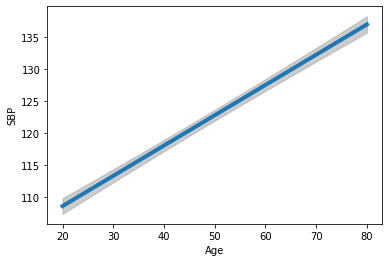

In [17]:
ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
_ = ax.set_ylabel("SBP")

The analogous plot for BMI is shown next.  Here we fix the gender as
"female" and the age at 50, so we are looking at the relationship
between expected SBP and age for women of age 50.

In [18]:
del values["BMXBMI"]
values["RIDAGEYR"] = 50
pr, cb, fv = predict_functional(result, "BMXBMI",
                values=values, ci_method="simultaneous")

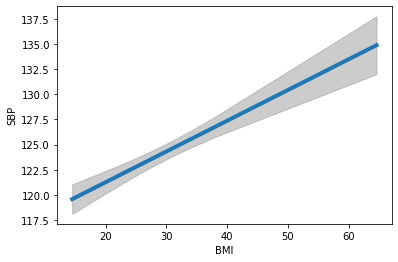

In [19]:
ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("BMI")
_ = ax.set_ylabel("SBP")

The error band for BMI is notably wider than the error band for age,
indicating that there is less certainty about the relationsuip
between BMI and SBP compared to the relationship between age and
SBP.  This is partly because the BMI values are less uniformly
distributed.  Very few subjects have BMI greater than 50, so we have
less information from the data about the population mean,
e.g. $E[y|a=50, g]$ in this area.  Since there is less information,
the uncertainty is greater, hence the error bands are wider.

## Visualizing variance structure

The discussion so far has primarily focused on the mean structure of
the population, that is, the model for the average SBP of a person
with a given age, gender, and BMI.  A regression model can also be
used to assess the *variance structure* of the population -- that is,
how much and in what manner the observations deviate from their mean.
We will focus on informal, graphical methods for assessing this.

To begin with, we plot the residuals against the fitted values.
Recall that the fitted values are the estimated means for each
observation, and the residuals are the difference between an
observation and its fitted mean.  For example, the model may estimate
that a 50 year old female will have on average an SBP of 125.  But a
specific 50 year old female may have a blood pressure of 110 or 150,
for example.  The fitted values for both of these women are 125, and
their residuals are -15, and 25, respectively.

The simplest variance pattern that we can see in a linear regression
occurs when the points are scattered around the mean, with the same
degree of scatter throughout the range of the covariates.  This is
called *homoescedasticity*, or *constant variance*.  When there are
multiple covariates, it is hard to assess whether the variance is
constant in this sense, but we can easily check for a "mean/variance
relationship", in which there is a systematic relationship between the
variance and the mean, i.e. the variance either increases or decreases
systematically with the mean.  The plot of residuals on fitted values
is used to assess whether such a mean/variance relationship is
present.

Below we show the plot of residuals on fitted values for the NHANES
data.  It appears that we have a modestly increasing mean/variance
relationship.  That is, the scatter around the mean blood pressure is
greater when the mean blood pressure itself is greater.

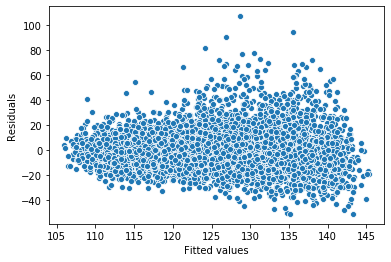

In [20]:
pp = sns.scatterplot(result.fittedvalues, result.resid)
pp.set_xlabel("Fitted values")
_ = pp.set_ylabel("Residuals")

A "component plus residual plot" or "partial residual plot" is
intended to show how the data would look if all but one covariate
could be fixed at reference values.  By controlling the values of
these covariates, all remaining variation is due either to the "focus
variable" (the one variable that is left unfixed, and is plotted on
the horizontal axis), or to sources of variation that are unexplained
by any of our covariates.

For example, the partial residual plot below shows how age (horizontal
axis) and SBP (vertical axis) would be related if gender and BMI were
fixed.  Note that the origin of the vertical axis in these plots is
not meaningful (we are not implying that anyone's blood pressure would
be negative), but the differences along the vertical axis are
meaningful.  This plot implies that when BMI and gender are held
fixed, the average blood pressures of an 80 and 18 year old differ by
around 30 mm/Hg.  This plot also shows, as discussed above, that the
deviations from the mean are somewhat smaller at the low end of the
range compared to the high end of the range.  We also see that at the
high end of the range, the deviations from the mean are somewhat
right-skewed, with exceptionally high SBP values being more common
than exceptionally low SBP values.

In [21]:
from statsmodels.graphics.regressionplots import plot_ccpr

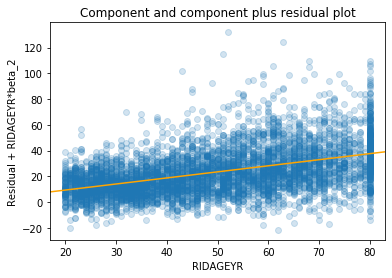

In [22]:
ax = plt.axes()
plot_ccpr(result, "RIDAGEYR", ax)
ax.lines[0].set_alpha(0.2) # Reduce overplotting with transparency
_ = ax.lines[1].set_color('orange')

Next we have a partial residual plot that shows how BMI (horizontal
axis) and SBP (vertical axis) would be related if gender and age were
fixed.  Compared to the plot above, we see here that age is more
uniformly distributed than BMI.  Also, it appears that there is more
scatter in the partial residuals for BMI compared to what we saw above
for age. Thus there seems to be less information about SBP in BMI,
although a trend certainly exists.

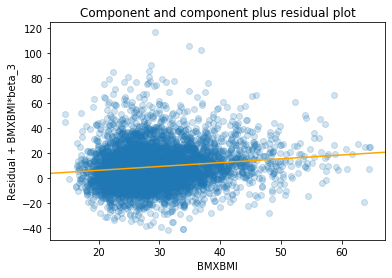

In [23]:
ax = plt.axes()
plot_ccpr(result, "BMXBMI", ax)
ax.lines[0].set_alpha(0.2)
ax.lines[1].set_color('orange')

# Assessing curvature

As noted above, a linear model is "linear" in an important technical
sense, but this does not mean that linear regression can only be used
to model linear phenomena.  The models that we fit above, however, are
all linear in terms of the specified mean structure relationship
between the covariates (age, etc.)  and the response (blood pressure).
To assess whether the data support this linear relationship, we can
use an *added variable plot*.  This is a diagnostic plot that aims to
show how the response is related to one of the predictors,
independently of how this relationship is specified in the model.
Thus, although we have modeled the mean structure relationship between
age (for example) and blood pressure as linear, the added variable
plot will allow us to see if the relationship deviates from this form.

The cell below shows the added variable plot for age in a model
including main effects for age, BMI, and gender.  Note that we are
using the GLM function here to fit the model.  GLM is a more general
class of regression procedures that includes linear regression (OLS)
as a special case.  OLS is the default for GLM, so the code below fits
the identical model as fit above with the OLS function.  Currently, it
is necessary to use GLM when fitting linear models if we want to
produce added variable plots.

In [24]:
from statsmodels.graphics.regressionplots import add_lowess

In [25]:
model = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()

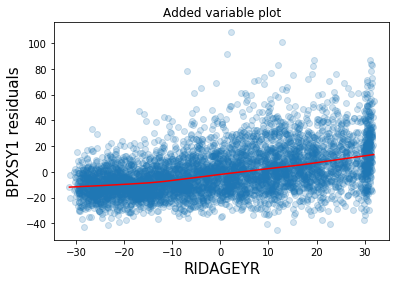

In [26]:
fig = result.plot_added_variable("RIDAGEYR")
fig.axes[0].lines[0].set_alpha(0.2)
_ = add_lowess(fig.axes[0], frac=0.5)

The plot above suggests that the increasing trend identified by the
linear model is approximately correct, but that the true relationship
may be slightly nonlinear, with positive curvature.  This means that
the annual mean increment in blood pressure may get larger as people
age.

We won't get into the mathematical details of how added variable plots
are constructed, but we note that the construction involves
residualization.  Therefore, the "focus variable" (age above) is
centered relative to its mean in the plot.

As another example, below is the added variable plot for BMI:

In [27]:
from statsmodels.graphics.regressionplots import add_lowess

In [28]:
model = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()

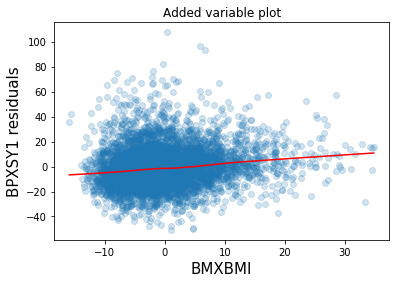

In [29]:
fig = result.plot_added_variable("BMXBMI")
fig.axes[0].lines[0].set_alpha(0.2)
_ = add_lowess(fig.axes[0], frac=0.5)

# Basis functions and splines

If we have identified possible nonlinear relationships that we would
like to include in a model, one way to accomplish this while remaining
within the framework of linear regression is to use basis functions.
A collection of basis functions is any collection of functions that we
can evaluate using one or more of the covariates in a model.  For
example, we may consider the polynomial basis functions $x, x^2,
\ldots$.  We can evaluate these polynomials using age, yielding ${\rm
age}, {\rm age}^2, \ldots$.  These variables can then be included in
the mean structure of the regression model:

$$
E[{\rm SBP} | {\rm age}, {\rm BMI}] = b_0 + b_1\cdot {\rm age} + b_2\cdot{\rm age}^2 + b_3\cdot {\rm BMI}.
$$

Note that this is still a linear model, since we can treat ${\rm
age}^2$ as simply being another covariate (like BMI) that we have
added to the model.  Thus, all of the techniques used for working with
linear models remain applicable here, although we are now able to
capture nonlinear relationships in the mean structure.  Also note that
above we included a polynomial (quadratic) term for age, but it would
be possible to simultaneously add polynomial terms for several terms
in the model (e.g. for both age and BMI).

In [30]:
da["RIDAGEYR_z"] = (da.RIDAGEYR - da.RIDAGEYR.mean()) / da.RIDAGEYR.std()
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR_z + I(RIDAGEYR_z**2) + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     465.1
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          4.21e-267
Time:                        23:29:34   Log-Likelihood:                -21505.
No. Observations:                5102   AIC:                         4.302e+04
Df Residuals:                    5098   BIC:                         4.304e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            123.8813      0.404    306.776      0.000     123.090     124.673
RIAGENDRx[T.Male]      3.2319      0.459      7.039      0.000       2.332       4.132
RIDAGEYR_z             8.3594      0.231     36.185      0.000       7.907       8.812
I(RIDAGEYR_z ** 2)     0.1859      0.248      0.750      0.453      -0.300       0.672
==============================================================================
Omnibus:                      708.996   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1594.809
Skew:                           0.819   Prob(JB):                         0.00
Kurtosis:                       5.196   Cond. No.                         3.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As seen above, the coefficient for ${\rm age}^2$ is not significantly
different from zero.  This is not the only arbiter of whether there is
curvature in the mean relationship between blood pressure and age, but
it does indicate that we are unable to estimate any curvature in these
data.

Polynomial basis function are easy to explain, but have been
criticized for being too "global" and for inducing collinearity.  The
term "global" in this context means that the fitted value at one point
$x$ in the covariate space may depend in unexpected ways on
observations $(y^\prime, x^\prime)$ for points $x^\prime$ that are far
from $x$.  A very popular family of basis functions that avoid this
issue are the various *spline* families, which are local polynomials.

In [31]:
model = sm.OLS.from_formula("BPXSY1 ~ bs(RIDAGEYR, 5) + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     219.0
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          2.76e-285
Time:                        23:29:34   Log-Likelihood:                -21451.
No. Observations:                5102   AIC:                         4.292e+04
Df Residuals:                    5094   BIC:                         4.297e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            103.6601      1.536     67.468      0.000     100.648     106.672
RIAGENDRx[T.Male]      3.6039      0.456      7.900      0.000       2.710       4.498
bs(RIDAGEYR, 5)[0]    -0.5552      2.268     -0.245      0.807      -5.002       3.891
bs(RIDAGEYR, 5)[1]     3.0907      1.575      1.962      0.050       0.002       6.179
bs(RIDAGEYR, 5)[2]    19.1714      2.124      9.024      0.000      15.007      23.336
bs(RIDAGEYR, 5)[3]    17.7960      1.762     10.099      0.000      14.341      21.251
bs(RIDAGEYR, 5)[4]    26.8944      1.498     17.955      0.000      23.958      29.831
BMXBMI                 0.3210      0.033      9.729      0.000       0.256       0.386
==============================================================================
Omnibus:                      745.462   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1773.011
Skew:                           0.837   Prob(JB):                         0.00
Kurtosis:                       5.353   Cond. No.                         459.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Below we plot the fitted mean curve, which is an estimate of $E[{\rm
SBP} | {\rm age}, {\rm gender}=F, {\rm BMI}=25]$, along with a 95%
simultaneous confidence band to assess the uncertainty.

In [32]:
del da["RIDAGEYR_z"]
values = {"RIAGENDRx": "Female", "RIAGENDR": 2, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1}

In [33]:
pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

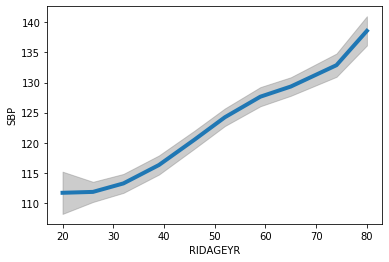

In [34]:
ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("RIDAGEYR")
_ = ax.set_ylabel("SBP")

# Interactions

The basic linear models we fit above are *additive*, meaning that
the change in the expected response associated with a change in one
covariate is not dependent on the values of the other covariates.
In the setting of a regression model with two covariates, additivity
implies that the value of

$$
E[y | x_1=a+1, x_2=x] - E[y | x_1=a, x_2=x]
$$

does not depend on $x$.  In the blood pressure example, additivity
would imply that the difference in mean blood pressure between a 50
year-old woman and a 40 year-old woman is the same as the difference
in mean blood pressure between a 50 year-old man and a 40 year-old
man.  In fact, this may not be the case.

Although nonlinearities and interactions can be considered jointly,
for simplicity we will return now to modeling the age and BMI
effects linearly, but include an *interaction* between age and
gender in the model.  This interaction allows us to explore
non-additivity between these variables.

Note that here we have centered the age variable.  While not
strictly required, there are several advantages to centering
quantitative variables that are part of an interaction term in a
regression model.  One specific advantage is that the main effects
for the variables in the interaction (here age and gender) are
interpretable as the effects of one of these variable while holding
the other variable fixed at its mean.  For example, the main effect
for gender in the model below is the difference in mean blood
pressure between women and men who are at the mean age of the
sample.

In [35]:
da["RIDAGEYR_cen"] = da.RIDAGEYR - da.RIDAGEYR.mean()
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR_cen*RIAGENDRx + BMXBMI", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     400.0
Date:                Sun, 26 Jan 2020   Prob (F-statistic):          4.37e-300
Time:                        23:29:35   Log-Likelihood:                -21425.
No. Observations:                5102   AIC:                         4.286e+04
Df Residuals:                    5097   BIC:                         4.289e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        115.0502      1.026    112.149      0.000     113.039     117.061
RIAGENDRx[T.Male]                  3.5785      0.454      7.889      0.000       2.689       4.468
RIDAGEYR_cen                       0.5766      0.018     32.394      0.000       0.542       0.611
RIDAGEYR_cen:RIAGENDRx[T.Male]    -0.2182      0.026     -8.533      0.000      -0.268      -0.168
BMXBMI                             0.3013      0.032      9.273      0.000       0.238       0.365
==============================================================================
Omnibus:                      773.113   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1861.274
Skew:                           0.861   Prob(JB):                         0.00
Kurtosis:                       5.406   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results shown above show that the main effects and interactions
are all statistically significant, which suggests that the roles of
age and gender with respect to blood pressure may not be additive.
Men have a higher intercept but lower slope than women.  The easiest
way to see what this tells us is through a graph:

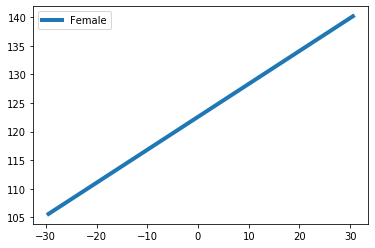

In [36]:
values["RIAGENDRx"] = "Female"
values["RIDAGEYR"] = np.nan
pr1, cb1, fv1 = predict_functional(result, "RIDAGEYR_cen",
                values=values, ci_method="simultaneous")
ax = sns.lineplot(fv1, pr1, lw=4, label="Female")

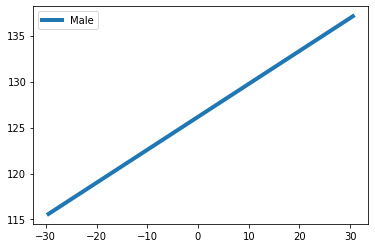

In [37]:
values["RIAGENDRx"] = "Male"
pr2, cb2, fv2 = predict_functional(result, "RIDAGEYR_cen",
                values=values, ci_method="simultaneous")
ax = sns.lineplot(fv2, pr2, lw=4, label="Male")

In [38]:
ax.set_xlabel("RIDAGEYR")
_ = ax.set_ylabel("SBP")